In [2]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 
import pandas as pd

In [3]:
def relabel(h):
    a = h.axis('dataset')
    for s in a.identifiers():
        if "testpoint" in s.name or "=" in s.name or len(s.name.split("_"))==0: continue
        if "HNL" in s.name:
            m = float(s.name.split("_")[-2].replace("mHNL","").replace("p","."))
            ct = int(s.name.split("_")[-1].replace("pl",""))
        #     print("m=%s,ct=%s"%(m,ct)    )
            a.index(s).label = "m=%s,ct=%s"%(m,ct)
        elif "WJets" in s.name:
            a.index(s).label = "Wjets"
    return 

In [4]:
import HNLprocessor.corrections as corrections

xsections = corrections.load_xsection()

with open('../HNL_histograms_Feb23_muons_data.pickle','rb') as f:                
# with open('../HNL_histograms_Feb3_muons.pickle','rb') as f:                
    out = pickle.load(f)
    
lumi = 137 ## fb
    
for k,h in out.items():
    print(k,)
#     if (type(h)!=hist.Hist): continue
#     h.scale({ d: lumi for d in h.identifiers("dataset") if d.name in xsections.keys()}, axis="dataset")
#     relabel(h)

nCluster
nCluster_dt
nCluster_n-1
accept
ClusterSize
ClusterTime
ClusterEta
ClusterAvgStation10
ClusterNStation10
dphi_cluster_csc
ClusterSize_dt
ClusterTime_dt
ClusterEta_dt
ClusterAvgStation10_dt
ClusterNStation10_dt
dphi_cluster_dt
nLeptons
elePt
eleEta
muPt
muEta
nJets
jetPt
jetMet_dPhi
metXYCorr
MT
nPU
nPU_noweight
gWPt
gWPt_noweight
glepdPhi
gLepPt
gLLP_e
gLLP_pt
gLLP_eta
sumw


## Some basic info of the input pickles

In [4]:
out['sumw']

defaultdict_accumulator(float,
                        {'Muon_2018A': 41528872.0,
                         'Muon_2018D': 65541022.0,
                         'Muon_2018B': 9311583.0,
                         'Muon_2018C': 8448336.0})

In [6]:
h=out['ClusterSize']
h.sum("dataset","region","ClusterSize").values()

{(): 10923.0}

In [9]:
out['dphi_cluster_csc'].identifiers("region")

[<StringBin (ABCD) instance at 0x7f0d2bccff10>,
 <StringBin (ABCD_OOT) instance at 0x7f0d2bccff50>]

In [70]:
out['dphi_cluster_dt'].identifiers("region")

[<StringBin (ABCD_dt) instance at 0x7f5df28e3610>,
 <StringBin (ABCD_dt_OOT) instance at 0x7f5df28e3350>]

In [7]:
def getABCD(dataset,A,B,C,D):   
    if dataset==None:
        a,a_err2 = A.values(True)[()]
        b,b_err2 = B.values(True)[()]
        c,c_err2 = C.values(True)[()]
        d,d_err2 = D.values(True)[()]
    else:
        a,a_err2 = A.values(True)[(dataset,)]
        b,b_err2 = B.values(True)[(dataset,)]
        c,c_err2 = C.values(True)[(dataset,)]
        d,d_err2 = D.values(True)[(dataset,)]
    
    r = {
        "A"   :"%.2f +- %.2f"%(a,a_err2**0.5),
        "B"   :"%.2f +- %.2f"%(b,b_err2**0.5), 
        "C"   :"%.2f +- %.2f"%(c,c_err2**0.5),
        "D"   :"%.2f +- %.2f"%(d,d_err2**0.5),        
        "pred":"%.2f +- %.2f"%(a*c/b,(a*c/b)*(a_err2/a**2+b_err2/b**2+c_err2/c**2)**0.5),        
    }
    return r

## hist.group demo

We can use `group` to re-define axis on-the-fly. Here, we are grouping the low/high rechit region into 2 categories.

<AxesSubplot:xlabel='$\\Delta\\phi$(cluster,lep)', ylabel='Events'>

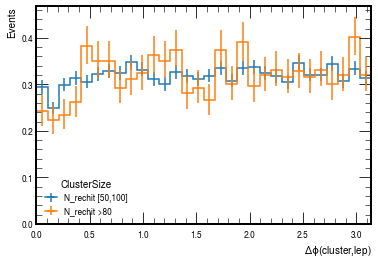

In [7]:
h = out['dphi_cluster_csc']
h= h.sum("dphi_MET")
data = ['Muon_2018A','Muon_2018B','Muon_2018C','Muon_2018D']
h = h.integrate("dataset",data).integrate("region","ABCD_OOT")

h_group = h.group("ClusterSize",
        hist.Cat("ClusterSize","ClusterSize",sorting="placement"),
        {
            "N_rechit [50,100]":slice(50,100),
            "N_rechit >80":slice(80,None),            
        }
)
hist.plot1d(h_group,overlay="ClusterSize",density=True)

# OOT CSC validation

In [18]:
# plt.style.use("default")
hep.set_style(hep.style.CMS)

def plotValidation_v2(h,region,label,lumi,Nhit_cut,dphi_cut,density=False,rebin_phi=1):
    fig, axs = plt.subplots(1,3, figsize=(27,9))

    axs = axs.flatten()
    
    h = h.integrate("region",region)

    hist.plot2d(h.project("dphi_lep","ClusterSize"),xaxis="ClusterSize",ax=axs[0])
    
    ## old_axis, new_axis, mapping
    h_group = h.group("ClusterSize",hist.Cat(label,label,sorting="placement"),
            {
#                 "N_rechit [50,100]":slice(50,100),
#                 "N_rechit [100,120]":slice(100,120),                
#                 "N_rechit [120,140]":slice(120,140),            
#                 "N_rechit >180":slice(180,None),      
                "N_rechit [50,%s]"%Nhit_cut:slice(50,Nhit_cut),            
                "N_rechit >%s"%Nhit_cut    :slice(Nhit_cut,None),                      
            }
    )        
    if rebin_phi!=1:
        hist.plot1d(h_group.rebin("dphi_lep",rebin_phi),overlay=label,ax=axs[1],density=density)    
    else:
        hist.plot1d(h_group,overlay=label,ax=axs[1],density=density)            

    h_group = h.group("dphi_lep",hist.Cat(label,label,sorting="placement"),
            {
                r'$\Delta\phi(cluster,lep)<%s$'%dphi_cut:slice(None,dphi_cut),
                r'$\Delta\phi(cluster,lep)>%s$'%dphi_cut:slice(dphi_cut,None),            
            }
    )        
    hist.plot1d(h_group,overlay=label,ax=axs[2],density=density)    

    axs[0].set_xlim(0,500)
    axs[2].set_xlim(0,500)
    axs[2].set_yscale("log")
    axs[2].set_ylim(0.1,None)
    if density:
        axs[2].set_ylim(1e-5,None)
        axs[1].set_ylabel("Density")
        axs[2].set_ylabel("Density")        
    
    for ax in axs:
        hep.cms.label(ax=ax,label="Preliminary",data=True,lumi=lumi)
    axs[1].legend(title=label,loc=1)   
    axs[2].legend(title=label,loc=1)           
        
    plt.tight_layout()
    
def plotValidation(h,region,label,lumi,density=False):
    fig, axs = plt.subplots(1,3, figsize=(27,9))

    axs = axs.flatten()
    
    hist.plot2d(h[(region)].project("dphi_lep","ClusterSize"),xaxis="ClusterSize",ax=axs[0])

    hist.plot1d(h[(region)].integrate("ClusterSize",slice(50,100)).project("dphi_lep"),ax=axs[1],clear=False,density=density)
    hist.plot1d(h[(region)].integrate("ClusterSize",slice(140,None)).project("dphi_lep"),ax=axs[1],clear=False,density=density)    

    hist.plot1d(h[(region)].integrate("dphi_lep",slice(2.0,None)).project("ClusterSize"),ax=axs[2],clear=False,density=density)
    hist.plot1d(h[(region)].integrate("dphi_lep",slice(2.5,None)).project("ClusterSize"),ax=axs[2],clear=False,density=density)

    axs[0].set_xlim(0,500)
    axs[2].set_xlim(0,500)
    axs[2].set_yscale("log")
    axs[2].set_ylim(0.1,None)

    for ax in axs:
        hep.cms.label(ax=ax,label="Preliminary",data=True,lumi=lumi)

    labels = ["N_rechit [50,100)","N_rechit >140"]
    axs[1].legend(labels,title=label)
    labels = [ r'$\Delta\phi(cluster,lep)>2.0$',r'$\Delta\phi(cluster,lep)>2.5$']
    axs[2].legend(labels,title=label,loc=1)

    plt.tight_layout()
    
def printClosure(h,sizeCuts,dphi_lep,dphi_cuts,size):
    data=[]
    for cut in sizeCuts:
        A = h.integrate("ClusterSize",slice(cut,None)).integrate("dphi_lep",slice(None,dphi_lep))
        B = h.integrate("ClusterSize",slice(None,cut)).integrate("dphi_lep",slice(None,dphi_lep))
        C = h.integrate("ClusterSize",slice(None,cut)).integrate("dphi_lep",slice(dphi_lep,None))
        D = h.integrate("ClusterSize",slice(cut,None)).integrate("dphi_lep",slice(dphi_lep,None))

        k=None
        row = getABCD(k,A,B,C,D)
        row["cut"]="N_hit>%s"%cut
        data.append(row)

    for cut in dphi_cuts:
        A = h.integrate("ClusterSize",slice(size,None)).integrate("dphi_lep",slice(None,cut))
        B = h.integrate("ClusterSize",slice(None,size)).integrate("dphi_lep",slice(None,cut))
        C = h.integrate("ClusterSize",slice(None,size)).integrate("dphi_lep",slice(cut,None))
        D = h.integrate("ClusterSize",slice(size,None)).integrate("dphi_lep",slice(cut,None))

        k=None
        row = getABCD(k,A,B,C,D)
        row["cut"]="dphi_lep>%s"%cut
        data.append(row)    
    df = pd.DataFrame(data, columns=["cut",'A', 'B', 'C', 'D',"pred"])
    return df

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:581: RuntimeWarning: Reducing along axis <Bin (name=dphi_lep) instance at 0x7fe559482390>: requested stop 2.0 between bin boundaries, no interpolation is performed
  RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:564: RuntimeWarning: Reducing along axis <Bin (name=dphi_lep) instance at 0x7fe559482390>: requested start 2.0 between bin boundaries, no interpolation is performed
  RuntimeWarning)


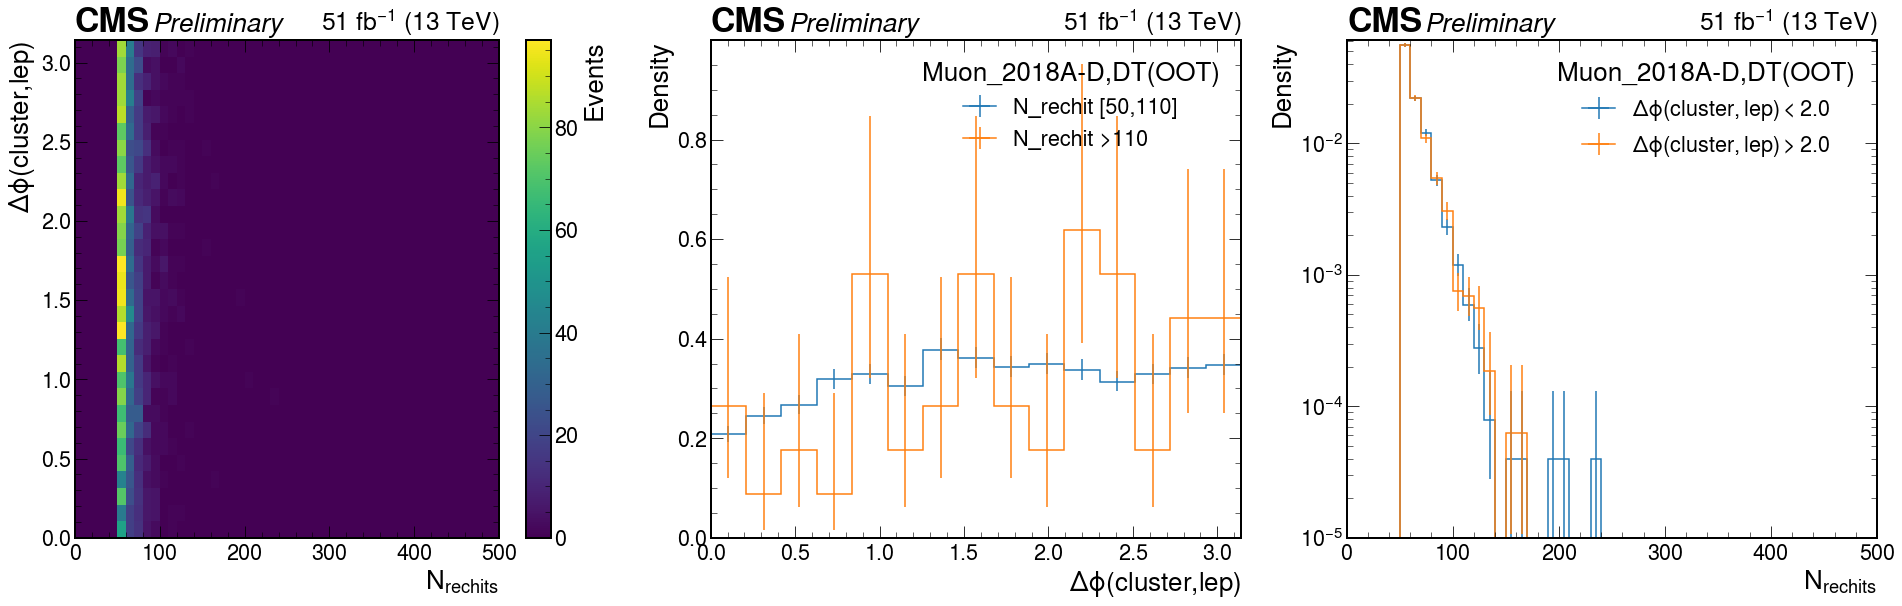

In [26]:
# plt.style.use("default")
hep.set_style(hep.style.CMS)

data = ['Muon_2018A','Muon_2018B','Muon_2018C','Muon_2018D']
lumi = "51"
label = "Muon_2018A-D,CSC(OOT)"
region = "ABCD_OOT"

h = out['dphi_cluster_csc']
h= h.sum("dphi_MET")
h = h.integrate("dataset",data)

# plotValidation(h,region,label,lumi,density=True)
# plotValidation_v2(h,region,label,lumi,200,2.0,density=True,rebin_phi=2)

### DT validation
data = ['Muon_2018A','Muon_2018B','Muon_2018C','Muon_2018D']
lumi = "51"
label = "Muon_2018A-D,DT(OOT)"
region = "ABCD_dt_OOT"

h = out['dphi_cluster_dt']
h= h.sum("dphi_MET")
h = h.integrate("dataset",data)
# plotValidation(h,region,label,lumi)
plotValidation_v2(h,region,label,lumi,110,2.0,density=True,rebin_phi=2)

In [16]:
h = out['dphi_cluster_csc']
h = h.integrate("region","ABCD_OOT")
h = h.sum("dphi_MET")
eras = ['Muon_2018A','Muon_2018B','Muon_2018C','Muon_2018D']

h = h.integrate("dataset",eras)
SizeCuts = [100,140,160,200,220]
dphi_lep_const = 2.0

dphi_cuts = [1.9,2.0,2.1]
size_const = 200

# CSC, Muon OOT closure
df=printClosure(h,SizeCuts,dphi_lep_const,dphi_cuts,size_const)

h = out['dphi_cluster_dt']
h = h.integrate("region","ABCD_dt_OOT")
h = h.sum("dphi_MET")
h = h.integrate("dataset",eras)
SizeCuts = [90,100,110]
dphi_lep_const = 2.0

dphi_cuts = [1.8,2.0,2.2]
size_const = 80

# printClosure(h,SizeCuts,dphi_lep_const,dphi_cuts,size_const)
df

,cut,A,B,C,D,pred
0,N_hit>100,611.00 +- 24.72,9079.00 +- 95.28,5419.00 +- 73.61,356.00 +- 18.87,364.69 +- 16.03
1,N_hit>140,152.00 +- 12.33,9538.00 +- 97.66,5705.00 +- 75.53,70.00 +- 8.37,90.92 +- 7.53
2,N_hit>160,94.00 +- 9.70,9596.00 +- 97.96,5739.00 +- 75.76,36.00 +- 6.00,56.22 +- 5.87
3,N_hit>200,37.00 +- 6.08,9653.00 +- 98.25,5762.00 +- 75.91,13.00 +- 3.61,22.09 +- 3.65
4,N_hit>220,30.00 +- 5.48,9660.00 +- 98.29,5769.00 +- 75.95,6.00 +- 2.45,17.92 +- 3.28
5,dphi_lep>1.9,36.00 +- 6.00,9106.00 +- 95.43,6309.00 +- 79.43,14.00 +- 3.74,24.94 +- 4.18
6,dphi_lep>2.0,37.00 +- 6.08,9653.00 +- 98.25,5762.00 +- 75.91,13.00 +- 3.61,22.09 +- 3.65
7,dphi_lep>2.1,38.00 +- 6.16,10198.00 +- 100.99,5217.00 +- 72.23,12.00 +- 3.46,19.44 +- 3.17


## In-time validation (dPhi_MET>0.75)

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:581: RuntimeWarning: Reducing along axis <Bin (name=dphi_lep) instance at 0x7fe559482390>: requested stop 2.0 between bin boundaries, no interpolation is performed
  RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:564: RuntimeWarning: Reducing along axis <Bin (name=dphi_lep) instance at 0x7fe559482390>: requested start 2.0 between bin boundaries, no interpolation is performed
  RuntimeWarning)


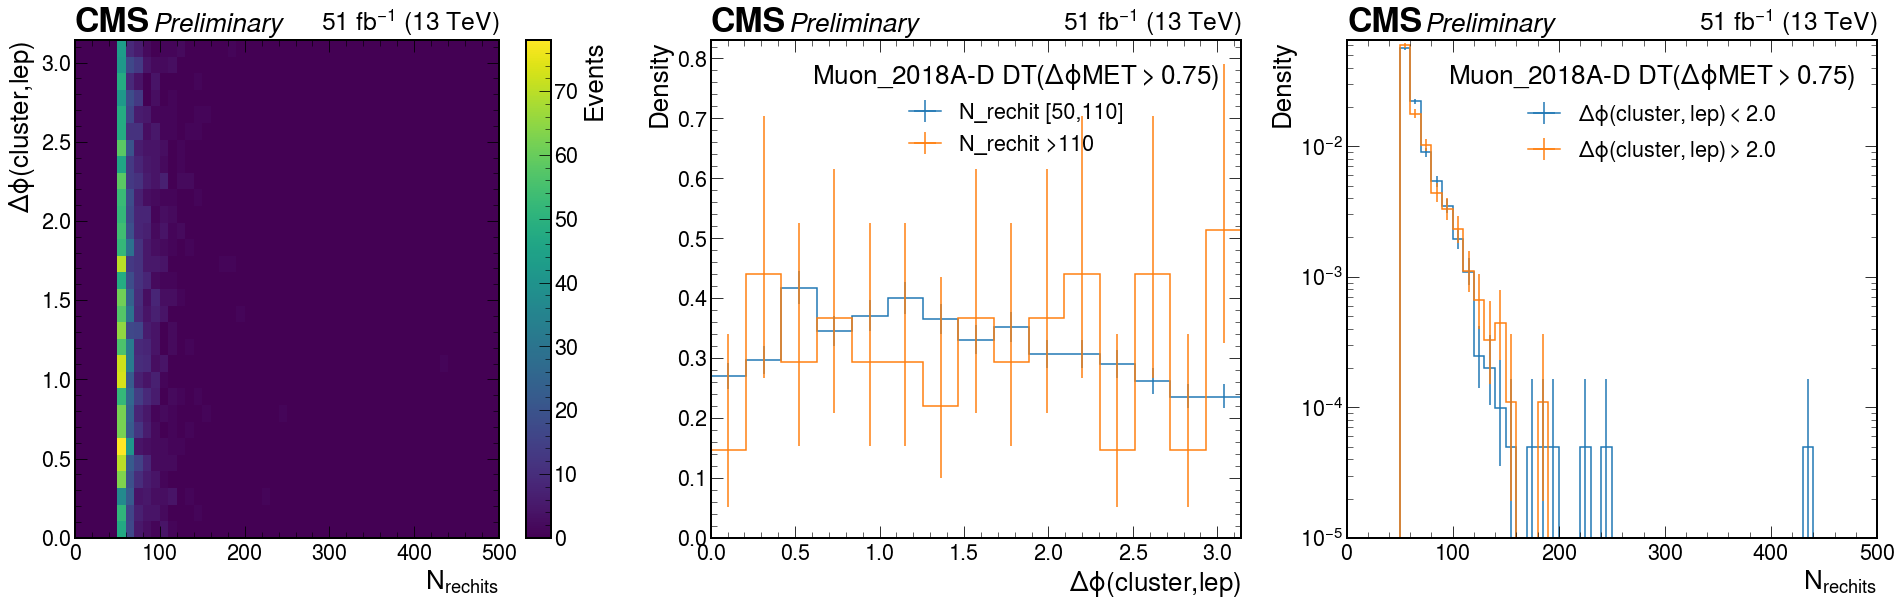

In [25]:
# plt.style.use("default")
hep.set_style(hep.style.CMS)

data = ['Muon_2018A','Muon_2018B','Muon_2018C','Muon_2018D']
lumi = "51"
label = "Muon_2018A-D CSC($\Delta\phi MET>0.75$)"
region = "ABCD"

h = out['dphi_cluster_csc']
h = h.integrate("dphi_MET",slice(0.75,None))
h = h.integrate("dataset",data)


### Muon, CSC, In-time
# plotValidation(h,region,label,lumi)
# plotValidation_v2(h,region,label,lumi,180,2.0,density=True,rebin_phi=2)

data = ['Muon_2018A','Muon_2018B','Muon_2018C','Muon_2018D']
lumi = "51"
label = "Muon_2018A-D DT($\Delta\phi MET>0.75$)"
region = "ABCD_dt"

h = out['dphi_cluster_dt']
h = h.integrate("dphi_MET",slice(0.75,None))
h = h.integrate("dataset",data)


### Muon, DT, In-time
# plotValidation(h,region,label,lumi)
plotValidation_v2(h,region,label,lumi,110,2.0,density=True,rebin_phi=2)

In [27]:
h = out['dphi_cluster_csc']
h = h.integrate("region","ABCD")
h = h.integrate("dphi_MET",slice(0.75,None))
eras = ['Muon_2018A','Muon_2018B','Muon_2018C','Muon_2018D']
h = h.integrate("dataset",eras)

SizeCuts = [100,140,160,200]
dphi_lep_const = 2.0

dphi_cuts = [1.9,2.0,2.1]
size_const = 200

# df= printClosure(h,SizeCuts,dphi_lep_const,dphi_cuts,size_const)

h = out['dphi_cluster_dt']
h = h.integrate("region","ABCD_dt")
h = h.integrate("dphi_MET",slice(0.75,None))
h = h.integrate("dataset",eras)
SizeCuts = [80,90,100,110]
dphi_lep_const = 2.0

dphi_cuts = [1.9,2.0,2.2]
size_const = 100
df=  printClosure(h,SizeCuts,dphi_lep_const,dphi_cuts,size_const)
df

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:564: RuntimeWarning: Reducing along axis <Bin (name=dphi_MET) instance at 0x7fe559469750>: requested start 0.75 between bin boundaries, no interpolation is performed
  RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:564: RuntimeWarning: Reducing along axis <Bin (name=dphi_MET) instance at 0x7fe5594824d0>: requested start 0.75 between bin boundaries, no interpolation is performed
  RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:581: RuntimeWarning: Reducing along axis <Bin (name=dphi_lep) instance at 0x7fe559482390>: requested stop 2.0 between bin boundaries, no interpolation is performed
  RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/si

,cut,A,B,C,D,pred
0,N_hit>80,257.00 +- 16.03,1755.00 +- 41.89,792.00 +- 28.14,116.00 +- 10.77,115.98 +- 8.77
1,N_hit>90,149.00 +- 12.21,1863.00 +- 43.16,832.00 +- 28.84,76.00 +- 8.72,66.54 +- 6.12
2,N_hit>100,79.00 +- 8.89,1933.00 +- 43.97,862.00 +- 29.36,46.00 +- 6.78,35.23 +- 4.22
3,N_hit>110,40.00 +- 6.32,1972.00 +- 44.41,883.00 +- 29.72,25.00 +- 5.00,17.91 +- 2.92
4,dphi_lep>1.9,72.00 +- 8.49,1843.00 +- 42.93,952.00 +- 30.85,53.00 +- 7.28,37.19 +- 4.63
5,dphi_lep>2.0,79.00 +- 8.89,1933.00 +- 43.97,862.00 +- 29.36,46.00 +- 6.78,35.23 +- 4.22
6,dphi_lep>2.2,87.00 +- 9.33,2102.00 +- 45.85,693.00 +- 26.32,38.00 +- 6.16,28.68 +- 3.32


## Background selection optimization

In [42]:
out['dphi_cluster_dt']["Muon_2018D"]

<Hist (dataset,region,ClusterSize,dphi_lep,dphi_MET) instance at 0x7ffa5bd28ed0>

In [8]:
h = out['dphi_cluster_csc']["Muon_2018D"]

OOT = h.integrate("region","ABCD_OOT")
inTime = h.integrate("region","ABCD")

hdt = out['dphi_cluster_dt']["Muon_2018D"]

OOT_dt = hdt.integrate("region","ABCD_dt_OOT")
inTime_dt = hdt.integrate("region","ABCD_dt")

inTime_dPhiMETcut = h.integrate("region","ABCD").integrate("dphi_MET",slice(0.733038285838,None))
inTime_dPhiMETcut_dt = hdt.integrate("region","ABCD_dt").integrate("dphi_MET",slice(0.733038285838,None))

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:564: RuntimeWarning: Reducing along axis <Bin (name=dphi_MET) instance at 0x7f8957353bd0>: requested start 0.733038285838 between bin boundaries, no interpolation is performed
  RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:564: RuntimeWarning: Reducing along axis <Bin (name=dphi_MET) instance at 0x7f8957322590>: requested start 0.733038285838 between bin boundaries, no interpolation is performed
  RuntimeWarning)


In [9]:
OOT_dPhiMETcut = OOT.integrate("dphi_MET",slice(0.733038285838,None))
OOT_dPhiMETcut_dt = OOT_dt.integrate("dphi_MET",slice(0.733038285838,None))

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:357: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:364: RuntimeWarning: divide by zero encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analy

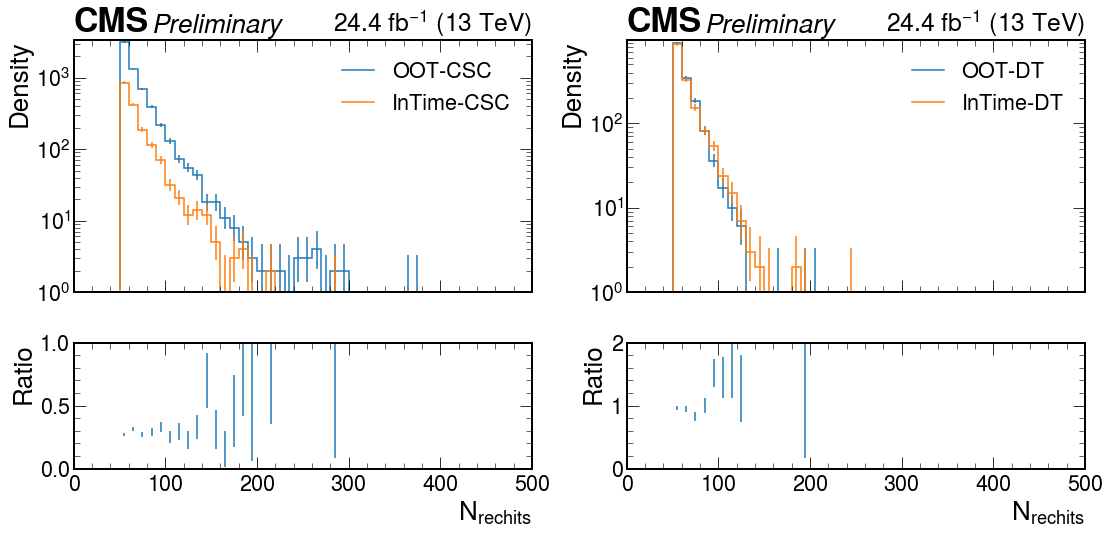

In [13]:
hep.set_style(hep.style.CMS)
fig, axs = plt.subplots(2,2, figsize=(16,8),gridspec_kw={"height_ratios":[2,1]},sharex=True)

density=False
projectTo = "ClusterSize"
axs = axs.flatten()

hist.plot1d(OOT_dPhiMETcut.project(projectTo),ax=axs[0],density=density,clear=False)
hist.plot1d(inTime_dPhiMETcut.project(projectTo),ax=axs[0],density=density,clear=False)

hist.plot1d(OOT_dPhiMETcut_dt.project(projectTo),ax=axs[1],density=density,clear=False)
hist.plot1d(inTime_dPhiMETcut_dt.project(projectTo),ax=axs[1],density=density,clear=False)

hist.plotratio(inTime_dPhiMETcut.project(projectTo), 
               OOT_dPhiMETcut.project(projectTo),unc="num",ax=axs[2],
               denom_fill_opts=None,error_opts="")

hist.plotratio(inTime_dPhiMETcut_dt.project(projectTo), 
               OOT_dPhiMETcut_dt.project(projectTo),unc="num",ax=axs[3],
               denom_fill_opts=None,error_opts="")
hep.cms.label(ax=axs[0],label="Preliminary",data=True,lumi="24.4")
hep.cms.label(ax=axs[1],label="Preliminary",data=True,lumi="24.4")
axs[0].set_xlabel("")
axs[0].legend(["OOT-CSC","InTime-CSC"])
if density==True:
    axs[0].set_xlim(0,500);axs[0].set_ylim(1e-6,1)
else:
    axs[0].set_xlim(0,500);axs[0].set_ylim(1,None)    
axs[0].set_yscale("log");axs[2].set_ylim(0,1)
axs[0].set_ylabel("Density");axs[2].set_ylabel("Ratio")
axs[1].set_xlabel("")
axs[1].legend(["OOT-DT","InTime-DT"])
if density==True:
    axs[1].set_xlim(0,500);axs[1].set_ylim(1e-6,1)
else:
    axs[1].set_xlim(0,500);axs[1].set_ylim(1,None)  
    
axs[1].set_yscale("log");axs[3].set_ylim(0,2)
axs[1].set_ylabel("Density");axs[3].set_ylabel("Ratio")


plt.tight_layout()

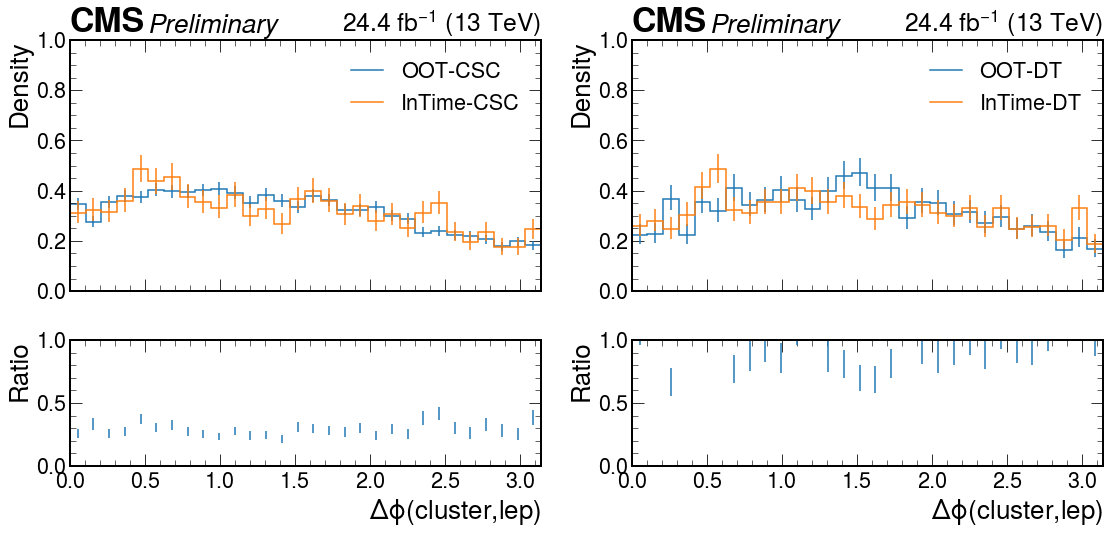

In [67]:
hep.set_style(hep.style.CMS)
fig, axs = plt.subplots(2,2, figsize=(16,8),gridspec_kw={"height_ratios":[2,1]},sharex=True)

projectTo = "dphi_lep"

axs = axs.flatten()

hist.plot1d(OOT_dPhiMETcut.project(projectTo),ax=axs[0],density=True,clear=False)
hist.plot1d(inTime_dPhiMETcut.project(projectTo),ax=axs[0],density=True,clear=False)

hist.plot1d(OOT_dPhiMETcut_dt.project(projectTo),ax=axs[1],density=True,clear=False)
hist.plot1d(inTime_dPhiMETcut_dt.project(projectTo),ax=axs[1],density=True,clear=False)

hist.plotratio(inTime_dPhiMETcut.project(projectTo), 
               OOT_dPhiMETcut.project(projectTo),unc="num",ax=axs[2],
               denom_fill_opts=None,error_opts="")

hist.plotratio(inTime_dPhiMETcut_dt.project(projectTo), 
               OOT_dPhiMETcut_dt.project(projectTo),unc="num",ax=axs[3],
               denom_fill_opts=None,error_opts="")
hep.cms.label(ax=axs[0],label="Preliminary",data=True,lumi="24.4")
hep.cms.label(ax=axs[1],label="Preliminary",data=True,lumi="24.4")

axs[0].set_xlabel("")
axs[0].legend(["OOT-CSC","InTime-CSC"])
axs[0].set_ylabel("Density")
axs[2].set_ylabel("Ratio")
axs[0].set_ylim(0,1)
axs[2].set_ylim(0,1)
axs[1].set_xlabel("")
axs[1].legend(["OOT-DT","InTime-DT"])
axs[1].set_ylabel("Density")
axs[3].set_ylabel("Ratio")
axs[1].set_ylim(0,1)
axs[3].set_ylim(0,1)

plt.tight_layout()

In [97]:
def predIntimeFromOOT(h,size,dphi_lep,dphi_met,isSignal=False,kfactor=0.25,lumi=137/23.):
 
    cut1 = slice(size,None)
    cut2 = slice(dphi_lep,None)
    cut3 = slice(None,dphi_met)
    D = h.integrate("ClusterSize",cut1).integrate("dphi_lep",cut2).integrate("dphi_MET",cut3)
#     A = h.integrate("ClusterSize",slice(cut,None)).integrate("dphi_lep",slice(None,2.0))
#     B = h.integrate("ClusterSize",slice(None,cut)).integrate("dphi_lep",slice(None,2.0))
#     C = h.integrate("ClusterSize",slice(None,cut)).integrate("dphi_lep",slice(2.0,None))
#     D = h.integrate("ClusterSize",slice(cut,None)).integrate("dphi_lep",slice(2.0,None))    
    if not isSignal:
        N_evt = list(D.values().values())[0] * kfactor * lumi
    else:
        N_evt = list(D.values().values())[0]         
    return N_evt

cut=70

sizeCuts = np.linspace(50,300,26)
dphi_lepCuts = np.linspace(0,np.pi,31)[1:-2]
# dphi_METCuts = np.linspace(0,np.pi,31)[1:-1]


In [98]:
np.linspace(50,300,26)

array([ 50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140., 150.,
       160., 170., 180., 190., 200., 210., 220., 230., 240., 250., 260.,
       270., 280., 290., 300.])

In [127]:
data = []
metCut = 0.7

kfactor=0.9
lumi = 137/23.

for cut in ak.cartesian([sizeCuts,dphi_lepCuts],axis=0):
    cut = cut.to_list()
    row =[cut[0],cut[1],metCut]
#     bkg = np.round(predIntimeFromOOT(OOT, cut[0],cut[1],metCut,False,kfactor,lumi),3)
#     sig = np.round(predIntimeFromOOT(signal, cut[0],cut[1],metCut,True,kfactor,lumi),3)
    bkg = np.round(predIntimeFromOOT(OOT_dt, cut[0],cut[1],metCut,False,kfactor,lumi),3)
    sig = np.round(predIntimeFromOOT(signal_dt, cut[0],cut[1],metCut,True,kfactor,lumi),3)
    
    row.append(bkg)
    row.append(sig)
    if bkg<10 and bkg>0:
        data.append(row)
    
import pandas as pd
df = pd.DataFrame(data, columns=["N_hit cut",'dPhi_lep cut', 'dphi_MET cut', 'Bkg', 'signal'])


/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:581: RuntimeWarning: Reducing along axis <Bin (name=dphi_MET) instance at 0x7ffa5bcad210>: requested stop 0.7 between bin boundaries, no interpolation is performed
  RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:581: RuntimeWarning: Reducing along axis <Bin (name=dphi_MET) instance at 0x7ffa62547850>: requested stop 0.7 between bin boundaries, no interpolation is performed
  RuntimeWarning)


In [128]:
df['s/b'] = df['signal']/df['Bkg']

In [129]:
x = df['N_hit cut'].to_numpy()
y = df['dPhi_lep cut'].to_numpy()
z = df['Bkg'].to_numpy()
sig = df['signal'].to_numpy()

In [130]:
max(sig/np.sqrt(z))

0.7674755066035245

In [131]:
df.loc[np.where((sig/np.sqrt(z))==max(sig/np.sqrt(z)))]

,N_hit cut,dPhi_lep cut,dphi_MET cut,Bkg,signal,s/b
0,110.0,2.199115,0.7,5.361,1.777,0.331468


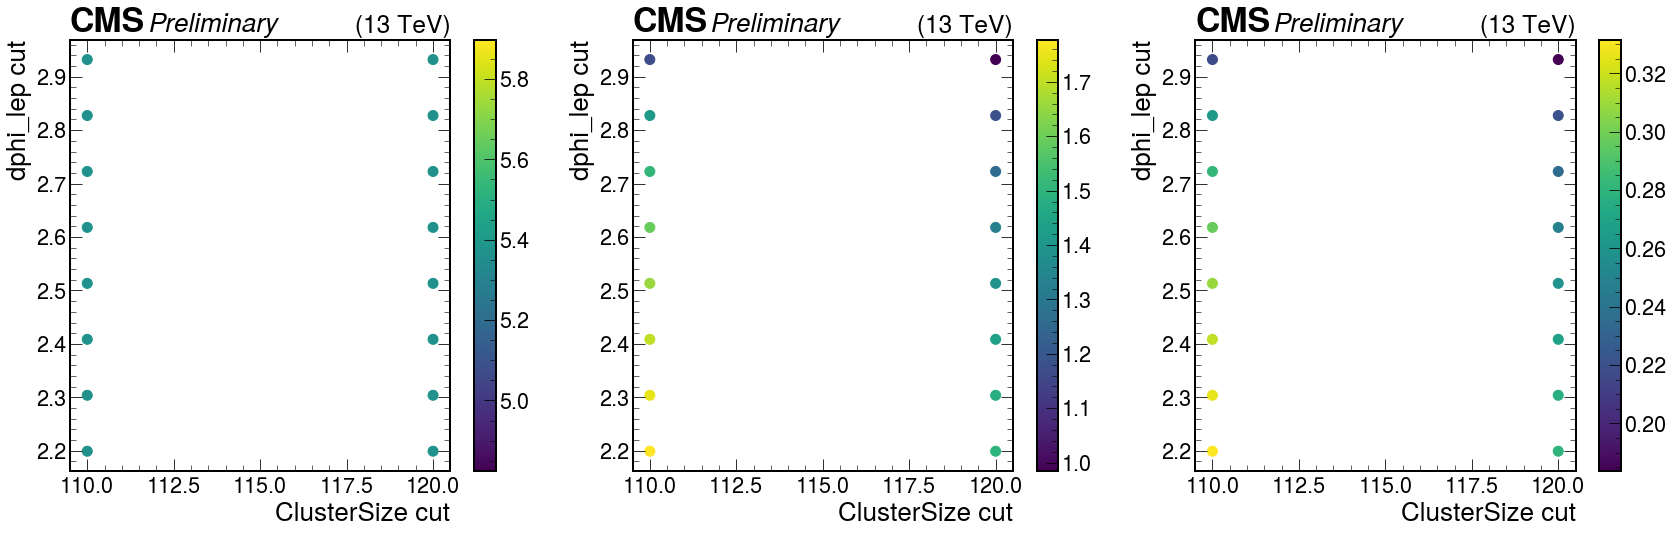

In [132]:
plt.style.use(hep.style.CMS) 

fig, axs = plt.subplots(1,3, figsize=(24,8))
axs = axs.flatten()

cax = axs[0].scatter(x,y,c=z,s=100)
fig.colorbar(cax, ax=axs[0])
cax = axs[1].scatter(x,y,c=sig,s=100)
fig.colorbar(cax, ax=axs[1])
cax = axs[2].scatter(x,y,c=sig/z,s=100)
fig.colorbar(cax, ax=axs[2])

for ax in axs:
    hep.cms.label(ax=ax,label="Preliminary",data=True)
    ax.set_xlabel("ClusterSize cut")
    ax.set_ylabel("dphi_lep cut")    
    
plt.tight_layout()

In [33]:
# HNL_histograms_Feb3_muons
with open('../HNL_histograms_muon_Jan28_signal.pickle','rb') as f:                
# with open('../HNL_histograms_Feb3_muons.pickle','rb') as f:                
    out_s = pickle.load(f)

import HNLprocessor.corrections as corrections

xsections = corrections.load_xsection()
lumi = 137 ## fb    
for k,h in out_s.items():
#     print(k,)
    if (type(h)!=hist.Hist): continue
    h.scale({ d: lumi for d in h.identifiers("dataset") if d.name in xsections.keys()}, axis="dataset")
    relabel(h)

In [69]:
h = out_s['dphi_cluster_csc']
signal = h.integrate("dataset",'HNL_muonType_mHNL4p0_pl1000').integrate("region","ABCD")
hdt = out_s['dphi_cluster_dt']
signal_dt = hdt.integrate("dataset",'HNL_muonType_mHNL4p0_pl1000').integrate("region","ABCD_dt")

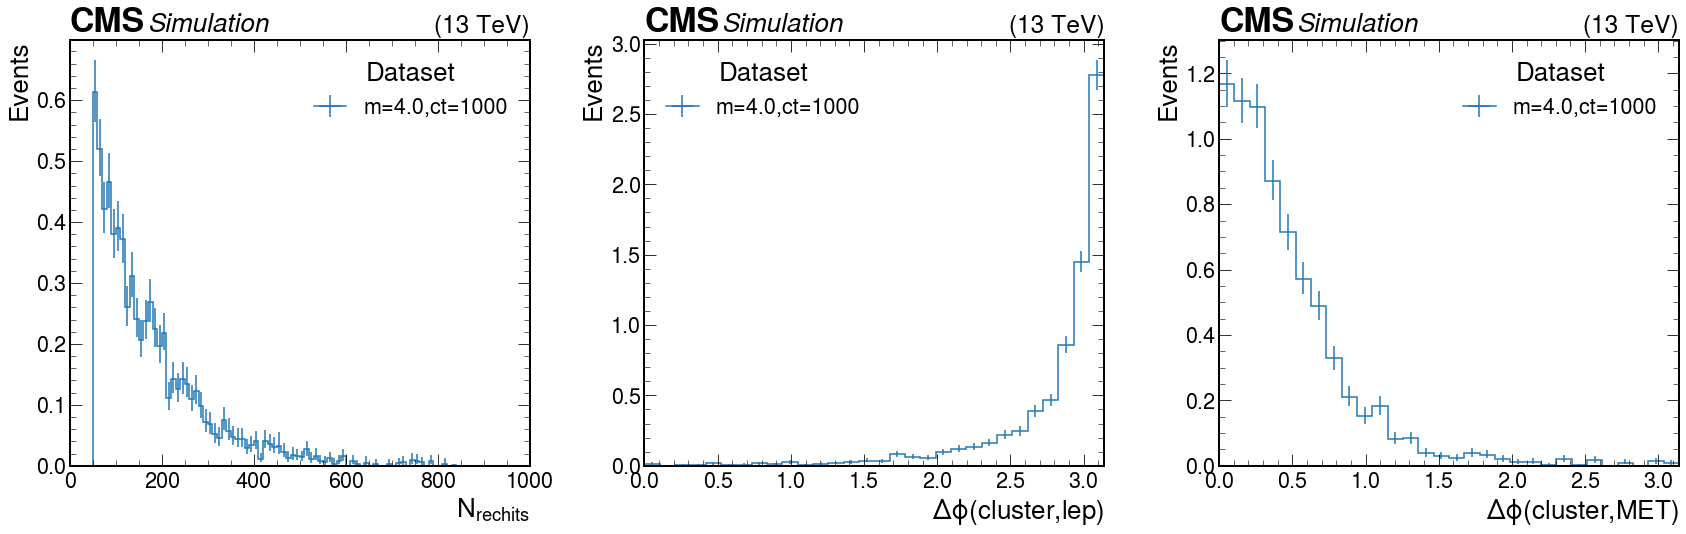

In [35]:
h = out_s['dphi_cluster_csc']
h = h['HNL_muonType_mHNL4p0_pl1000'].integrate("region","ABCD")
plt.style.use(hep.style.CMS) 

fig, axs = plt.subplots(1,3, figsize=(24,8))
axs = axs.flatten()

hist.plot1d(h.project("ClusterSize","dataset"),ax=axs[0])
hist.plot1d(h.project("dphi_lep","dataset"),ax=axs[1])
hist.plot1d(h.project("dphi_MET","dataset"),ax=axs[2])

for ax in axs:
    hep.cms.label(ax=ax,label="",data=False)
# axs[0].legend(["OOT","InTime"])    
#     ax.set_xlabel("ClusterSize cut")
#     ax.set_ylabel("dphi_lep cut")    
    
plt.tight_layout()

## Cluster ID distributions

In [157]:
out

{'nCluster': <Hist (dataset,region,nCluster,cutFlow) instance at 0x7ffa62559750>,
 'nCluster_dt': <Hist (dataset,region,nCluster,cutFlow) instance at 0x7ffa5bcf7350>,
 'nCluster_n-1': <Hist (dataset,nCluster,Nminus1) instance at 0x7ffa5bcf7d90>,
 'accept': <Hist (dataset,gLLP_csc,gLLP_dt) instance at 0x7ffa5bcf7f50>,
 'ClusterSize': <Hist (dataset,region,ClusterSize) instance at 0x7ffa5b776b10>,
 'ClusterTime': <Hist (dataset,region,ClusterTime) instance at 0x7ffa604c4dd0>,
 'ClusterEta': <Hist (dataset,region,ClusterEta) instance at 0x7ffa6260f250>,
 'ClusterAvgStation10': <Hist (dataset,region,ClusterAvgStation10) instance at 0x7ffa607f4c50>,
 'ClusterNStation10': <Hist (dataset,region,ClusterNStation10) instance at 0x7ffa62b39610>,
 'dphi_cluster_csc': <Hist (dataset,region,ClusterSize,dphi_lep,dphi_MET) instance at 0x7ffa605dd350>,
 'ClusterSize_dt': <Hist (dataset,region,ClusterSize) instance at 0x7ffa5bae9dd0>,
 'ClusterTime_dt': <Hist (dataset,region,ClusterBx) instance at 0x7ff

In [134]:
out['ClusterNStation10'][signals].integrate("region","ABCD").values()

{('HNL_muonType_mHNL1p0_pl10',): array([ 0.        , 47.37057391, 27.89465847, 10.70164763,  0.        ]),
 ('HNL_muonType_mHNL1p0_pl1000',): array([0.        , 7.373657  , 6.69870843, 1.40540338, 0.        ]),
 ('HNL_muonType_mHNL1p0_pl100',): array([  0.        , 216.99307731, 230.59324839,  50.54518513,
          0.        ])}

In [160]:
signals = [
#     'HNL_muonType_mHNL10p0_pl100',
#  'HNL_muonType_mHNL10p0_pl1000',
#  'HNL_muonType_mHNL10p0_pl10000',
#  'HNL_muonType_mHNL1p0_pl10',
#  'HNL_muonType_mHNL1p0_pl100',
#  'HNL_muonType_mHNL1p0_pl1000',
#  'HNL_muonType_mHNL2p0_pl10',
#  'HNL_muonType_mHNL2p0_pl100',
#  'HNL_muonType_mHNL2p0_pl1000',
#  'HNL_muonType_mHNL4p0_pl10',
#  'HNL_muonType_mHNL4p0_pl100',
#  'HNL_muonType_mHNL4p0_pl1000',
#  'HNL_muonType_mHNL7p0_pl100',
#  'HNL_muonType_mHNL7p0_pl1000',
#  'HNL_muonType_mHNL7p0_pl10000',
    "EGamma_2018C","EGamma_2018A","EGamma_2018D","EGamma_2018B"
  ]

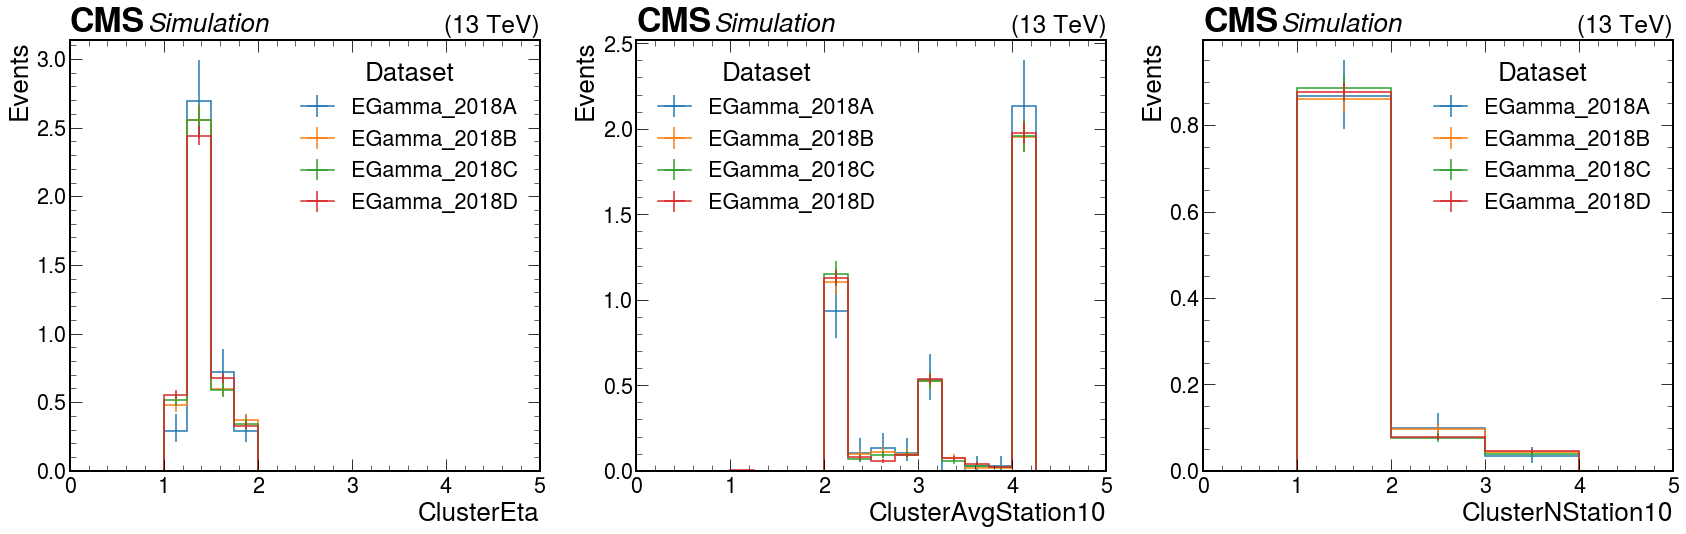

In [162]:
#
# h = out['Cluster']
h1=out['ClusterEta'][signals].integrate("region","ABCD_OOT")
h2=out['ClusterAvgStation10'][signals].integrate("region","ABCD_OOT")
h3=out['ClusterNStation10'][signals].integrate("region","ABCD_OOT")

plt.style.use(hep.style.CMS) 

fig, axs = plt.subplots(1,3, figsize=(24,8))
axs = axs.flatten()

hist.plot1d(h1.project("ClusterEta","dataset"),ax=axs[0],density=True)
hist.plot1d(h2.project("ClusterAvgStation10","dataset"),ax=axs[1],density=True)
hist.plot1d(h3.project("ClusterNStation10","dataset"),ax=axs[2],density=True)

for ax in axs:
    hep.cms.label(ax=ax,label="",data=False)
  
axs[0].set_xlim(0,None)
plt.tight_layout()